## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDOneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Add more classification lib here
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import classification_report, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import silhouette_score,silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
import pickle

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
df = pd.read_csv('telco_data_clean.csv', index_col=False)
df.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,...,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,monthly_charges_cat,tenure_year
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Low Expense,1
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,No,Medium Expense,3
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Medium Expense,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Medium Expense,4
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Medium High Expense,1


In [3]:
def exploreNumCol(df,  col):
    mean = df[col].mean()
    median = df[col].median()
    modus = df[col].mode().values[0]

    min = df[col].min()
    max = df[col].max()

    print(f'Mean {col} = {mean:.2f}')
    print(f'Median {col} = {median}')
    print(f'Modus {col} = {modus}')
    print(f'Min {col} = {min}')
    print(f'Max {col} = {max}')

    skew = df[col].skew()
    if skew < 0.5:
        print(f'Skewness {col} = {skew}, data distribution is normal')
    else:
        print(f'Skewness {col} = {skew}, data distribution is not normal')

In [4]:
numCol = ['tenure',	'monthly_charges',	'total_charges']
for nCol in numCol:
    exploreNumCol(df, nCol)
    print('')

Mean tenure = 32.42
Median tenure = 29.0
Modus tenure = 1
Min tenure = 1
Max tenure = 72
Skewness tenure = 0.23773083190513133, data distribution is normal

Mean monthly_charges = 64.80
Median monthly_charges = 70.35
Modus monthly_charges = 20.05
Min monthly_charges = 18.25
Max monthly_charges = 118.75
Skewness monthly_charges = -0.22210292770166232, data distribution is normal

Mean total_charges = 2283.30
Median total_charges = 1397.475
Modus total_charges = 20.2
Min total_charges = 18.8
Max total_charges = 8684.8
Skewness total_charges = 0.9616424997242504, data distribution is not normal



> Handling outlier sudah tak kerjakan di data_engineer --GILANG

In [5]:
def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df, bins=30) if variable is None else sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df) if variable is None else sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

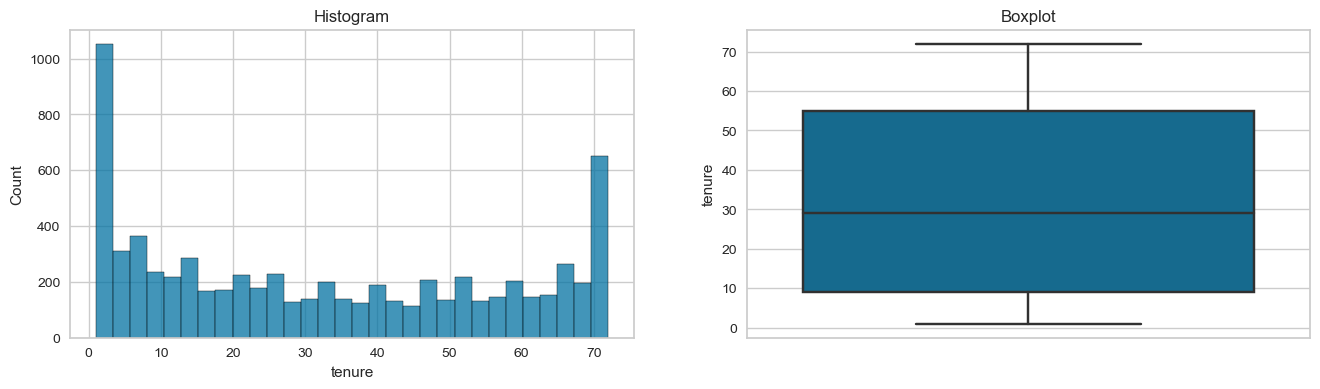

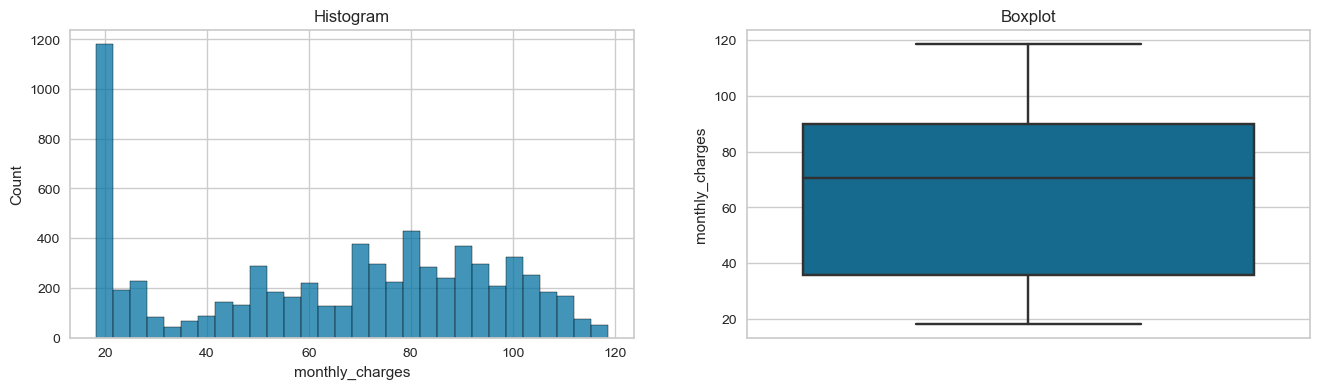

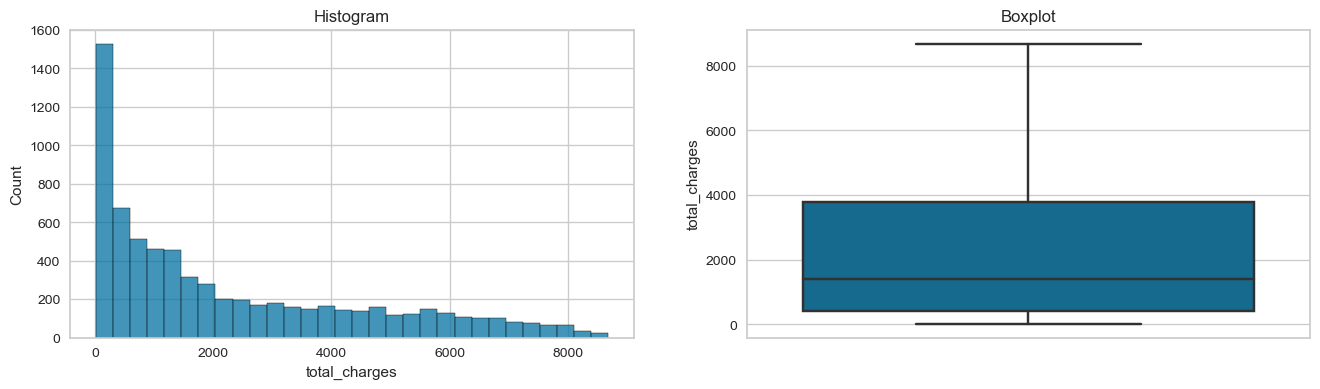

In [6]:
numCol = ['tenure',	'monthly_charges',	'total_charges']
for nCol in numCol:
    diagnostic_plots(df, nCol)

In [7]:
df.columns

Index(['gender', 'senior_citizen', 'partner', 'dependents', 'tenure',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn',
       'monthly_charges_cat', 'tenure_year'],
      dtype='object')

In [8]:
catCol = ['gender', 'senior_citizen', 'partner', 'dependents',
       'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method']

# Prediction Model

## Split Features

In [9]:
X = df.drop('churn', axis =  1)
y = df['churn']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=2)

print('Train Size :',X_train.shape)

print('Test Size :',X_test.shape)

X_train

Train Size : (5625, 21)
Test Size : (1407, 21)


,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,monthly_charges_cat,tenure_year
4742,Male,No,No,No,9,No,No phone service,DSL,Yes,Yes,...,No,No,No,One year,No,Mailed check,39.55,373.00,Medium Expense,1
1894,Male,No,No,No,17,Yes,No,Fiber optic,No,Yes,...,No,No,Yes,Month-to-month,Yes,Credit card (automatic),90.95,1612.20,High Expense,2
3322,Male,No,Yes,No,66,Yes,Yes,Fiber optic,No,Yes,...,No,No,Yes,One year,No,Electronic check,95.30,6273.40,High Expense,6
5117,Female,No,Yes,No,11,Yes,Yes,Fiber optic,No,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.00,1078.90,High Expense,1
1783,Female,No,Yes,No,57,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),19.60,1134.25,Low Expense,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6443,Male,No,No,No,15,Yes,Yes,Fiber optic,Yes,No,...,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),87.75,1242.20,Medium High Expense,2
3606,Male,No,No,No,21,Yes,Yes,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,73.70,1558.70,Medium High Expense,2
5704,Male,Yes,No,No,49,Yes,Yes,DSL,Yes,Yes,...,Yes,No,Yes,Two year,No,Credit card (automatic),81.35,4060.90,Medium High Expense,5
6637,Male,No,Yes,Yes,51,Yes,No,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,One year,No,Mailed check,19.40,997.75,Low Expense,5


## Split Columns

In [11]:
X_train_num = X_train[numCol]
X_train_cat = X_train[catCol]

X_test_num = X_test[numCol]
X_test_cat = X_test[catCol]

## Feature Scaling

In [12]:
skewed_transformer = Pipeline([
    ('standard', StandardScaler())
])

## Feature Encoding

In [13]:
categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder())
])

## Merge Data

In [14]:
preprocessor = ColumnTransformer(transformers=[
    ('skewed', skewed_transformer, numCol),
    ('cat', categorical_transformer, catCol)
])

## Model Definition

In [15]:
pipe_logreg = Pipeline([('preprocessor',preprocessor),('classifier',LogisticRegression())])
pipe_knn = Pipeline([('preprocessor',preprocessor),('classifier',KNeighborsClassifier())])
pipe_svm = Pipeline([('preprocessor',preprocessor),('classifier',SVC())]) 
pipe_dt = Pipeline([('preprocessor',preprocessor),('classifier',DecisionTreeClassifier())])
pipe_rf = Pipeline([('preprocessor',preprocessor),('classifier',RandomForestClassifier())])

## Model Training

In [16]:
pipe_logreg.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'senior_citizen',
                                                   'partner', 'dependents',
                                                   'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', LogisticRegression())])

In [17]:
pipe_knn.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'senior_citizen',
                                                   'partner', 'dependents',
                                                   'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', KNeighborsClassifier())])

In [18]:
pipe_svm.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'senior_citizen',
                                                   'partner', 'dependents',
                                                   'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', SVC())])

In [19]:
pipe_dt.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'senior_citizen',
                                                   'partner', 'dependents',
                                                   'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', DecisionTreeClassifier())])

In [20]:
pipe_rf.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('skewed',
                                                  Pipeline(steps=[('standard',
                                                                   StandardScaler())]),
                                                  ['tenure', 'monthly_charges',
                                                   'total_charges']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['gender', 'senior_citizen',
                                                   'partner', 'dependents',
                                                   'phone_service',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_protection',
                                                   'tech_support',
                                                   'streaming_tv',
                                                   'streaming_movies',
                                                   'contract',
                                                   'paperless_billing',
                                                   'payment_method'])])),
                ('classifier', RandomForestClassifier())])

## Model Evaluation

In [21]:
def performance_check(clf, X, y):
  y_pred = clf.predict(X)

  return precision_score(y, y_pred, pos_label='Yes')

### Logistic Regression Evaluation

In [22]:
y_pred_train_logreg = pipe_logreg.predict(X_train)
y_pred_test_logreg = pipe_logreg.predict(X_test)

y_pred_train_logreg

array(['No', 'Yes', 'No', ..., 'No', 'No', 'Yes'], dtype=object)

In [23]:
print('Precision - Train : ', performance_check(pipe_logreg, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_logreg, X_test, y_test))

Precision - Train :  0.6584786053882726
Precision - Test  :  0.6497005988023952


### KNN Evaluation

In [24]:
y_pred_train_knn = pipe_knn.predict(X_train)
y_pred_test_knn = pipe_knn.predict(X_test)

y_pred_train_knn

array(['No', 'No', 'No', ..., 'No', 'No', 'Yes'], dtype=object)

In [25]:
print('Precision - Train : ', performance_check(pipe_knn, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_knn, X_test, y_test))

Precision - Train :  0.7196467991169978
Precision - Test  :  0.5305039787798409


### SVM Evaluation

In [26]:
y_pred_train_svm = pipe_svm.predict(X_train)
y_pred_test_svm = pipe_svm.predict(X_test)

y_pred_train_svm

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [27]:
print('Precision - Train : ', performance_check(pipe_svm, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_svm, X_test, y_test))

Precision - Train :  0.7115902964959568
Precision - Test  :  0.6598639455782312


### DecisionTree Evaluation

In [28]:
y_pred_train_dt = pipe_svm.predict(X_train)
y_pred_test_dt = pipe_svm.predict(X_test)

y_pred_train_dt

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [29]:
print('Precision - Train : ', performance_check(pipe_dt, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_dt, X_test, y_test))

Precision - Train :  0.9986531986531987
Precision - Test  :  0.47785547785547783


### RandomForest Evaluation

In [30]:
y_pred_train_rf = pipe_svm.predict(X_train)
y_pred_test_rf = pipe_svm.predict(X_test)

y_pred_train_rf

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [31]:
print('Precision - Train : ', performance_check(pipe_rf, X_train, y_train))
print('Precision - Test  : ', performance_check(pipe_rf, X_test, y_test))

Precision - Train :  0.9953177257525083
Precision - Test  :  0.6208053691275168


# Clustering

In [32]:
dfnew = df.loc[(df['churn']=='Yes')]
dfnew.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,...,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn,monthly_charges_cat,tenure_year
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Medium Expense,1
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Medium High Expense,1
5,Female,No,No,No,8,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,High Expense,1
8,Female,No,Yes,No,28,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,High Expense,3
13,Male,No,No,No,49,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,High Expense,5


In [33]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1869 entries, 2 to 7030
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               1869 non-null   object 
 1   senior_citizen       1869 non-null   object 
 2   partner              1869 non-null   object 
 3   dependents           1869 non-null   object 
 4   tenure               1869 non-null   int64  
 5   phone_service        1869 non-null   object 
 6   multiple_lines       1869 non-null   object 
 7   internet_service     1869 non-null   object 
 8   online_security      1869 non-null   object 
 9   online_backup        1869 non-null   object 
 10  device_protection    1869 non-null   object 
 11  tech_support         1869 non-null   object 
 12  streaming_tv         1869 non-null   object 
 13  streaming_movies     1869 non-null   object 
 14  contract             1869 non-null   object 
 15  paperless_billing    1869 non-null   o

In [34]:
columns = ['senior_citizen','partner','dependents','tenure','online_security',
                'online_backup','device_protection','tech_support','contract',
                'paperless_billing','monthly_charges','total_charges','churn']

In [35]:
dfnew = dfnew.drop(columns=[col for col in dfnew if col not in columns])

In [36]:
dfnew.columns

Index(['senior_citizen', 'partner', 'dependents', 'tenure', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'contract',
       'paperless_billing', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

In [37]:
new_num = ['tenure', 'monthly_charges', 'total_charges']
new_cat = ['senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'contract',
       'paperless_billing', 'churn']

In [38]:
dfnew['tenure'].skew()

1.1492802882380029

In [39]:
dfnew['monthly_charges'].skew()

-0.7293738092658485

In [40]:
dfnew['total_charges'].skew()

1.5109145987042816

In [41]:
scaler = StandardScaler()
dfnew_scaled = scaler.fit_transform(dfnew[new_num])

In [42]:
dfnew_final = np.concatenate([dfnew_scaled, dfnew[new_cat]], axis=1)
dfnew_final = pd.DataFrame(dfnew_final, columns=['tenure', 'monthly_charges', 'total_charges'] + new_cat)
dfnew_final = dfnew_final.infer_objects()

In [43]:
dfnew_final

,tenure,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,contract,paperless_billing,churn
0,-0.818356,-0.835028,-0.753126,No,No,No,Yes,Yes,No,No,Month-to-month,Yes,Yes
1,-0.818356,-0.151720,-0.730114,No,No,No,No,No,No,No,Month-to-month,Yes,Yes
2,-0.511072,1.022272,-0.376284,No,No,No,No,No,Yes,No,Month-to-month,Yes,Yes
3,0.513209,1.231117,0.801058,No,Yes,No,No,No,Yes,Yes,Month-to-month,Yes,Yes
4,1.588704,1.186509,1.853924,No,No,No,No,Yes,Yes,No,Month-to-month,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1864,-0.306216,-0.593741,-0.425323,No,No,No,No,No,No,Yes,One year,Yes,Yes
1865,-0.459858,-1.226359,-0.596961,No,No,No,No,No,No,No,Month-to-month,Yes,Yes
1866,-0.869570,0.053070,-0.770266,Yes,No,No,No,No,No,No,Month-to-month,Yes,Yes
1867,2.510556,1.156095,2.832569,No,No,No,Yes,Yes,Yes,No,Month-to-month,Yes,Yes


In [44]:
index_cat_columns = [dfnew_final.columns.get_loc(col) for col in new_cat]

print('Categorical columns        : ', new_cat)
print('Categorical columns index  : ', index_cat_columns)

Categorical columns        :  ['senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'contract', 'paperless_billing', 'churn']
Categorical columns index  :  [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Cluster creation :  2
Cluster creation :  3
Cluster creation :  4
Cluster creation :  5
Cluster creation :  6


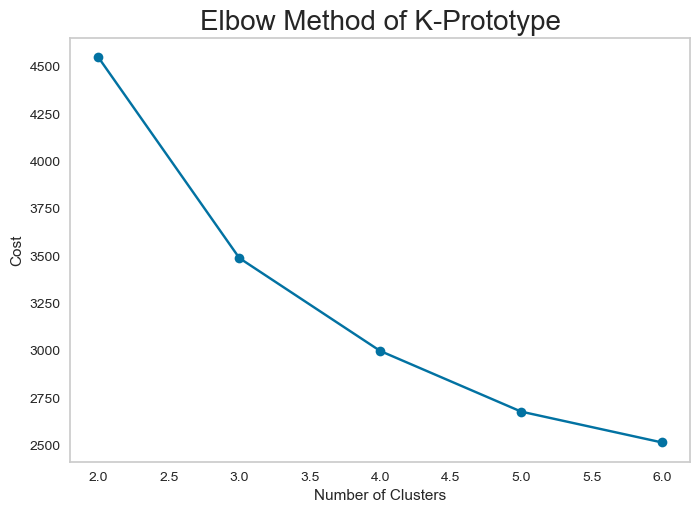

In [45]:
max_clusters = 6
cost = []
for k in range(2, max_clusters+1):
  kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42, n_jobs=-1)
  kproto.fit_predict(dfnew_final, categorical=index_cat_columns)
  cost.append(kproto.cost_)
  print('Cluster creation : ', k)

plt.plot(range(2, max_clusters+1), cost, marker ="o")
plt.grid()
plt.title('Elbow Method of K-Prototype', fontsize = 20)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.show()

In [46]:
kp = KPrototypes(n_clusters=3, random_state=42)
pred = kp.fit_predict(dfnew_final, categorical=index_cat_columns)
pred

array([1, 2, 2, ..., 2, 0, 2], dtype=uint16)

In [47]:
dfnew['cluster'] = pred
dfnew

,senior_citizen,partner,dependents,tenure,online_security,online_backup,device_protection,tech_support,contract,paperless_billing,monthly_charges,total_charges,churn,cluster
2,No,No,No,2,Yes,Yes,No,No,Month-to-month,Yes,53.85,108.15,Yes,1
4,No,No,No,2,No,No,No,No,Month-to-month,Yes,70.70,151.65,Yes,2
5,No,No,No,8,No,No,Yes,No,Month-to-month,Yes,99.65,820.50,Yes,2
8,No,Yes,No,28,No,No,Yes,Yes,Month-to-month,Yes,104.80,3046.05,Yes,0
13,No,No,No,49,No,Yes,Yes,No,Month-to-month,Yes,103.70,5036.30,Yes,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7010,No,No,No,12,No,No,No,Yes,One year,Yes,59.80,727.80,Yes,1
7015,No,No,No,9,No,No,No,No,Month-to-month,Yes,44.20,403.35,Yes,1
7021,Yes,No,No,1,No,No,No,No,Month-to-month,Yes,75.75,75.75,Yes,2
7023,No,No,No,67,Yes,Yes,Yes,No,Month-to-month,Yes,102.95,6886.25,Yes,0


<Axes: >

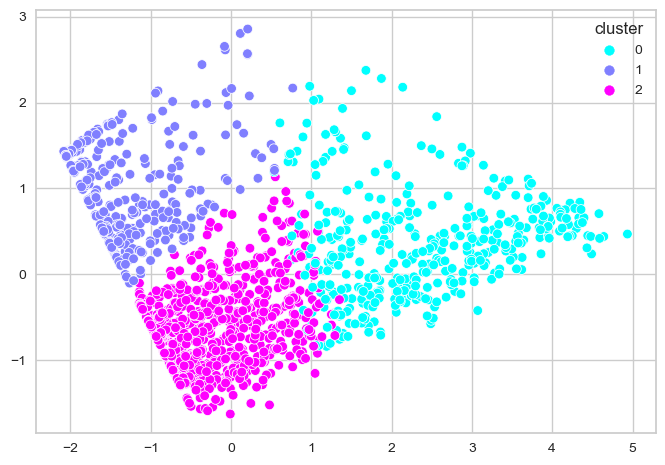

In [52]:
pca_2d = PCA(n_components=2)
pca_2d.fit(dfnew_scaled)

dfnew_scaled_pca_2d = pca_2d.fit_transform(dfnew_scaled)

sns.scatterplot(x=dfnew_scaled_pca_2d[:,0], y=dfnew_scaled_pca_2d[:,1], hue=dfnew['cluster'], palette='cool')

In [ ]:
dfnew[dfnew['cluster']==0].describe()

,tenure,monthly_charges,total_charges,cluster
count,412.000000,412.000000,412.000000,412.0
mean,48.900485,93.731675,4602.154490,0.0
std,12.743675,15.312319,1519.420739,0.0
min,24.000000,41.050000,2145.000000,0.0
25%,38.750000,85.337500,3232.612500,0.0
50%,48.500000,98.775000,4393.275000,0.0
75%,59.000000,104.650000,5742.937500,0.0
max,72.000000,118.350000,8684.800000,0.0


In [ ]:
dfnew[dfnew['cluster']==1].describe()

,tenure,monthly_charges,total_charges,cluster
count,469.000000,469.000000,469.000000,469.0
mean,8.029851,38.423348,307.247015,1.0
std,11.351191,13.396341,431.646216,0.0
min,1.000000,18.850000,18.850000,1.0
25%,1.000000,24.500000,45.100000,1.0
50%,3.000000,43.750000,104.200000,1.0
75%,10.000000,49.950000,374.500000,1.0
max,61.000000,62.050000,2203.650000,1.0


In [ ]:
dfnew[dfnew['cluster']==2].describe()

,tenure,monthly_charges,total_charges,cluster
count,988.000000,988.000000,988.000000,988.0
mean,9.807692,83.494787,832.733198,2.0
std,8.958164,10.720652,761.525560,0.0
min,1.000000,57.150000,68.500000,2.0
25%,2.000000,74.700000,164.875000,2.0
50%,7.000000,82.000000,580.050000,2.0
75%,15.000000,91.325000,1308.175000,2.0
max,38.000000,112.950000,3019.250000,2.0
